### Packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import h5py
import warnings
import matplotlib.pyplot as plt
import os
os.chdir(os.path.split(os.getcwd())[0])

### Read data

In [2]:
with h5py.File(".\\dataset\\DeepONet\\unitData.h5", 'r') as f:
  d = list(f["solEvalPoints"])
  # IDs of nodes used as trunk network inputs
  nodeID = list(map(int, d[0]))
  # [x y t] of y points (trunk inputs).
  # matrix with rows [x y t]
  solEvalPoint = torch.tensor(np.concatenate([d[1][:, None], d[2][:, None], d[3][:, None]], axis = 1))
  # DeepONet output targets (G(u)(y)) for all initial conditions
  # matrix with 'initial condition' rows and 'y point' columns
  with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    solutionValue = torch.tensor(f["solutionValues"]).T
del d
print(solEvalPoint.shape)
print(solutionValue.shape)

torch.Size([1000, 3])
torch.Size([1000, 1000])


### Data parameters

In [3]:
# number of sensors is equal to number of cases
nCase = solutionValue.shape[0]
nSensor = solutionValue.shape[0]
# value of concentrated load as initial condition
load = torch.tensor(-1.21 * 0.02).to(torch.float32)
evalAmount = solEvalPoint.shape[0] # number of y points (trunk inputs)
nSample = torch.numel(solutionValue) # amount of samples in dataset
print("Dataset contains {:_} samples.".format(nSample))

Dataset contains 1_000_000 samples.


### Organize data

In [4]:
class acoustDataset(torch.utils.data.Dataset):
    """Dataset subclass to organize data"""
    def __init__(self, evalPoint: torch.tensor, solVal: torch.tensor) -> None:
        super(acoustDataset, self).__init__()
        self.trunkInput = evalPoint
        # target for model output
        self.target = torch.flatten(solVal)
    
    def __getitem__(self, idx):
        """Overwrite method to fetch sample"""
        # branch input load value at specific sensor. 0 everywhere else
        branchInput = torch.zeros(nSensor, dtype = torch.float32)
        branchInput[idx - (idx // nCase) * nCase] = load
        # index to access tensor with coordinates of evaluation point (trunk inputs)
        i = idx - (idx // evalAmount) * evalAmount
        trunkIn = [
            self.trunkInput[i, s].unsqueeze(0) for s in range(3)
        ]
        # sample has (case evaluation at sensors, x, y, t, G(u)(y))
        return branchInput, *trunkIn, self.target[idx].unsqueeze(0)
    
    def __len__(self):
        """Overwrite method to return size of dataset"""
        return torch.numel(self.target)

In [5]:
dataloader = torch.utils.data.DataLoader(acoustDataset(solEvalPoint, solutionValue),
    batch_size = 256, shuffle = True, num_workers = 0
)
branchBatch, xBatch, yBatch, tBatch, targetBatch = next(iter(dataloader))
print(f"""Batch shapes:
  branch network inputs: {branchBatch.shape}
  trunk network inputs:
    x {xBatch.shape}
    y {yBatch.shape}
    t {tBatch.shape}
  model output targets: {targetBatch.shape}""")

Batch shapes:
  branch network inputs: torch.Size([256, 1000])
  trunk network inputs:
    x torch.Size([256, 1])
    y torch.Size([256, 1])
    t torch.Size([256, 1])
  model output targets: torch.Size([256, 1])


### ML parameters

In [6]:
branchDepth = 7 # number of layers in branch network (MLP architecture)
branchWidth = 100 # number of neurons in layers of branch network (MLP architecture)
trunkDepth = 7 # number of layers in trunk network (MLP architecture)
trunkWidth = 100 # number of neurons in layers of trunk network (MLP architecture)
networkOutputDim = 100 # dimension of outputs of networks

### Setup model

In [7]:
class branchNet(nn.Module):
    """Branch network definition"""
    def __init__(self, inDim: int, nnDepth: int, nnWidth: int):
        super().__init__()
        # Input layer. Resizes input to desired network width
        self.inputLayer = nn.Linear(inDim, nnWidth)
        # intermediate dense layers. constant dimension
        self.MLPstack = nn.ModuleList([nn.Linear(nnWidth, nnWidth) for _ in range(nnDepth - 2)])
        # output layer. resizes network intermediate representation to networkOutputDim
        self.outputLayer = nn.Linear(nnWidth, networkOutputDim)

    def forward(self, x): # forward pass
        x = F.leaky_relu(self.inputLayer(x))
        for l in self.MLPstack:
            x = F.leaky_relu(l(x))
        return self.outputLayer(x)
    
class trunkNet(nn.Module):
    """Trunk network definition"""
    def __init__(self, nnDepth: int, nnWidth: int):
        super().__init__()
        # Input layer. Resizes input to desired network width.
        # Consider trunk network as receiving individual inputs
        # for each dimension (x, y, t)
        self.xCoord = nn.Linear(1, nnWidth)
        self.yCoord = nn.Linear(1, nnWidth)
        self.tCoord = nn.Linear(1, nnWidth)
        # intermediate dense layers. constant dimension
        self.MLPstack = nn.ModuleList([nn.Linear(nnWidth, nnWidth) for _ in range(nnDepth - 2)])
        # output layer. resizes network intermediate representation to networkOutputDim
        self.outputLayer = nn.Linear(nnWidth, networkOutputDim)

    def forward(self, x, y, t): # forward pass
        x = F.leaky_relu(self.xCoord(x))
        y = F.leaky_relu(self.yCoord(y))
        t = F.leaky_relu(self.tCoord(t))
        o = x + y + t
        for l in self.MLPstack:
            o = F.leaky_relu(l(o))
        return self.outputLayer(o)
    
# Branch network. Embeds evaluations of the input functions 'u' at sensors
branchNetwork = branchNet(nSensor, branchDepth, branchWidth)
branchOut = branchNetwork(branchBatch)
# Trunk network. Embeds spatiotemporal coordinates (x, y, t) of
# point y, in which the PDE solution (G(u)(y)) is evaluated
trunkNetwork = trunkNet(trunkDepth, trunkWidth)
trunkOut = trunkNetwork(xBatch, yBatch, tBatch)
# Shapes of outputs of networks
print(f"""Branch - batched input {branchBatch.shape} -> output: {branchOut.shape}.
Trunk - batched input ({xBatch.shape}, {yBatch.shape}, {tBatch.shape}) -> output: {trunkOut.shape}.""")

class PI_deepONet(nn.Module):
    """Class for physics-informed DeepONet"""
    def __init__(self, branch: nn.Module, trunk: nn.Module):
        super().__init__()
        self.branch = branch
        self.trunk = trunk

    def forward(self, case: torch.tensor, x: torch.tensor, y: torch.tensor, t: torch.tensor):
        # transpose trunk output and multiply both for
        # sample-by-sample dot product in diagonal of result
        return F.leaky_relu(
            torch.diagonal(
                torch.matmul(self.branch(case),
                self.trunk(x, y, t).T)
            ).unsqueeze(1)
        )
    
model = PI_deepONet(branchNetwork, trunkNetwork)
modelOut = model(branchBatch, xBatch, yBatch, tBatch)
print(f"Batch PI-DeepONet output shape: {modelOut.shape}")

Branch - batched input torch.Size([256, 1000]) -> output: torch.Size([256, 100]).
Trunk - batched input (torch.Size([256, 1]), torch.Size([256, 1]), torch.Size([256, 1])) -> output: torch.Size([256, 100]).
Batch PI-DeepONet output shape: torch.Size([256, 1])


Optimizer

In [8]:
opt = torch.optim.SGD(model.parameters(), lr = 1e-3)

### Train

EPOCH   1

loss: 6.4833e-01  [0/3907]
loss: 1.0428e-02  [1000/3907]
loss: 1.0629e-02  [2000/3907]
loss: 8.6013e-03  [3000/3907]


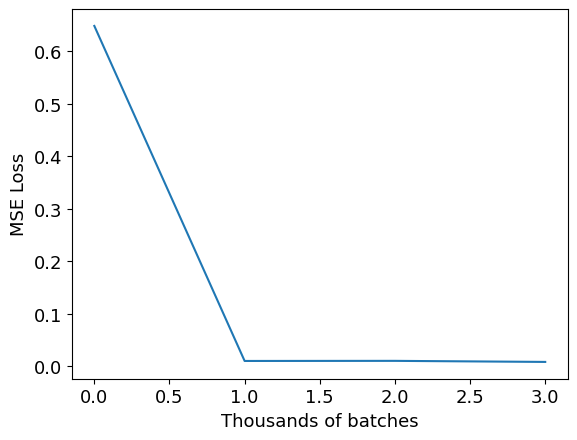

In [9]:
plt.rcParams['font.size'] = 13
def train_loop(dataloader, deepONet, loss_fn, optimizer, epochAmount):
    lossHist = []
    # Set the model to training mode. Added for best practices
    deepONet.train()
    for epoch in range(epochAmount): # epochs
        print(f"EPOCH   {epoch + 1}\n")
        # iterate in batches
        for (batch, (sampleCase, sampleX, sampleY, sampleT, sampleG_uy)) in enumerate(dataloader):
            # Compute prediction and loss
            modelOut = deepONet(sampleCase, sampleX, sampleY, sampleT)
            loss = loss_fn(modelOut, sampleG_uy)
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 1000 == 0: # occasional print
                currentLoss = loss.item()
                print("loss: {:.4e}  [{:n}/{:n}]".format(currentLoss, batch, len(dataloader)))
                lossHist.append(currentLoss)
        plt.plot(lossHist)
        plt.xlabel('Thousands of batches')
        plt.ylabel('MSE Loss')
        plt.show()

train_loop(dataloader, model, torch.nn.functional.mse_loss, opt, 1);